In [1]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd
import os
os.chdir('/content/drive/MyDrive/Panos/Εργασία Summarizer')
!pwd

/content
/content/drive/MyDrive/Panos/Εργασία Summarizer


In [ ]:
!pip install datasets

In [ ]:
!pip install -U accelerate
!pip install -U transformers

In [ ]:
!pip install torch

In [ ]:
!pip install rouge-score nltk -q

In [ ]:
# Import the train set's 0002.parquet file

import pandas as pd

# Replace with the actual path to your Parquet file
file_path = '/content/drive/MyDrive/Panos/Εργασία Summarizer/train_cnn_dailymail/0002.parquet'

# Reading the parquet file
final_df = pd.read_parquet(file_path, engine='pyarrow')  # or engine='fastparquet'

In [ ]:
print(len(final_df))

55113


In [ ]:
# Replace "highlights" column with "summary" column

final_df = final_df.rename(columns={'text':'document', 'highlights':'summary'})
final_df = final_df.dropna()

In [ ]:
final_df.head(10)

,article,summary,id
0,"(CNN)Share, and your gift will be multiplied. ...",Zully Broussard decided to give a kidney to a ...,a4942dd663020ca54575471657a0af38d82897d6
1,"(CNN)On the 6th of April 1996, San Jose Clash ...",The 20th MLS season begins this weekend .\nLea...,4157bc4da185971e2742f349d69a037343bc0d95
2,"(CNN)French striker Bafetimbi Gomis, who has a...",Bafetimbi Gomis collapses within 10 minutes of...,60736693e3b1b32d14337a317190c6606e879a85
3,(CNN)It was an act of frustration perhaps more...,Rory McIlroy throws club into water at WGC Cad...,8cdf9cc3ed0276b7a7944cc18ba459355b5984ad
4,(CNN)A Pennsylvania community is pulling toget...,"Cayman Naib, 13, hasn't been heard from since ...",2e6613d531843515bf5401286cc3e45c4df530d2
5,(CNN)My vote for Father of the Year goes to Cu...,Ruben Navarrette: Schilling deserves praise fo...,fbc5ac3a3a7bb6c4d628cfbeef92b67bb18562f9
6,"(CNN)Another one for the ""tourists behaving ba...",Two American women arrested for carving initia...,d093aa07380f75e63265793fcaa171772a6f4616
7,(CNN)Following last year's successful U.K. tou...,It will be a first time for the tour stateside...,0485e4f199828cd03857391cbe573142193ca953
8,(CNN)A shooting at a bar popular with expatria...,A jihadist group claims responsibility in an a...,c6df0bbd0b5eaa67e1f2b70892bf0a5dfb761895
9,(CNN)Manchester United defender Jonny Evans an...,Alleged incident happened in match at St James...,4a323dd3a1be975d93e941361082937cd2aafc88


In [ ]:
# Data Cleaning

import pandas as pd
import nltk
from nltk.corpus import stopwords
import string

# Download stopwords from NLTK
nltk.download('stopwords')

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # # Remove stopwords
    # stop_words = set(stopwords.words('english'))
    # words = text.split()
    # text = " ".join([word for word in words if word not in stop_words])

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
final_df['article']= final_df['article'].apply(lambda x: clean_text(x))
final_df['summary'] = final_df['summary'].apply(lambda x: clean_text(x))

In [6]:
# Load a small T5 model | 60m parameters

from transformers import AutoTokenizer
model_checkpoint ='t5-small'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
pad_on_right = tokenizer.padding_side == "right"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [9]:
import torch
import datasets
from datasets import Dataset
from datasets import load_metric

In [10]:
import torch
import transformers
print(transformers.__version__)

4.36.2


In [ ]:
tokenizer("Hello, this one sentence!")

{'input_ids': [8774, 6, 48, 80, 7142, 55, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [18]:
# Set maximum input length and target length

max_input_length = 1024
max_target_length = 128

In [ ]:
# Split the data in train, test and validation

# Calculate split sizes
train_size = int(0.8 * len(final_df))
val_size = int(0.1 * len(final_df))
test_size = len(final_df) - train_size - val_size  # Ensures all data is used

# Split the DataFrame
train = final_df[:train_size]
val = final_df[train_size:train_size+val_size]
test = final_df[train_size+val_size:]

train.shape, val.shape,test.shape

# Or use that custom splitting, depending on your needs

# final_df = final_df.sample(frac=1).reset_index(drop=True)
# train = final_df[:3350]
# valid = final_df[3350:3690]
# test = final_df[3690:3700]
# test_2 = final_df[3700:3720]
# train.shape, valid.shape,test.shape, test_2.shape

((44090, 3), (5511, 3), (5512, 3))

In [ ]:
# Preprocess function

def preprocess_function(examples):
    inputs = ['summarize:' + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding='max_length')

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [11]:
# Create Dataset objects

import torch
import datasets
from datasets import Dataset

train = Dataset.from_pandas(train)
valid = Dataset.from_pandas(valid)

In [ ]:
# Tokenize the train and validation sets

tokenized_train = train.map(preprocess_function, batched=True)
tokenized_valid = valid.map(preprocess_function, batched=True)

Map:   0%|          | 0/3350 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3860: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/340 [00:00<?, ? examples/s]

In [12]:
# Import transformers

import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [13]:
# Import model checkpoint

from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# Define batch size and the data collator

batch_size = 16
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
# Function to compute metrics for the training proccess

import nltk
import numpy as np

def compute_metrics(eval_pred):

    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
import gc

gc.collect()

217

In [15]:
# determine the device we will be using for training
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("[INFO] training using {}".format(torch.cuda.get_device_name(0)))
#print('There are %d GPU(s) available.' % torch.cuda.device_count())

[INFO] training using Tesla T4


In [ ]:
torch.cuda.empty_cache()

In [ ]:
%env WANDB_DISABLED=True

env: WANDB_DISABLED=True


In [ ]:
# Set model hyperparameters

model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-newsarticles_3.5k_sents",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=True
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# Define trainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
# Load Rouge metric

metric = load_metric("rouge")

<ipython-input-28-7154407f1f07>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
# Train the model

trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,1.541179,21.508400,10.243000,18.587100,20.525000,19.000000
2,No log,1.532936,21.347100,10.157000,18.419700,20.324000,19.000000
3,1.649600,1.525222,21.415300,10.243000,18.556000,20.282900,18.994100
4,1.649600,1.524461,21.452500,10.331500,18.622100,20.334300,18.994100
5,1.600100,1.523975,21.424200,10.278400,18.601200,20.309700,18.994100


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


TrainOutput(global_step=1050, training_loss=1.623704572405134, metrics={'train_runtime': 1016.4956, 'train_samples_per_second': 16.478, 'train_steps_per_second': 1.033, 'total_flos': 4533950349312000.0, 'train_loss': 1.623704572405134, 'epoch': 5.0})

In [ ]:
# Load model for inference, either the 45k or 7k model

# model_name = "t5-small-finetuned-newsarticles_45k_sents/checkpoint-13500"
model_name = "t5-small-finetuned-newsarticles_7k_sents/checkpoint-2000"
model_dir = f"/content/drive/MyDrive/Panos/Εργασία Summarizer/{model_name}"

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)

model.to(DEVICE)

In [44]:
# Inference code for testing articles one by one

import nltk
nltk.download('punkt')

text = "Summarize the text:" + """Residents of central Sanaa, the Yemeni capital, have learned the hard way that key strategic bombing targets are located in their neighborhoods: Detonating ordnance has been shattering their windows and doors. And fighting has killed hundreds of people in less than two weeks. The Saudi-led coalition smashed parts of Yemen's Defense Ministry Central Command in the capital over the weekend, senior Yemeni officials said. Under the rain of coalition bombs, the Houthis, who are Shiites in a majority Sunni country, still control Sanaa. But the airstrikes have hurt them and destroyed a lot of infrastructure. The electricity has gone out on 16 million Yemenis living in Houthi-held areas, the Yemeni officials said. Many fear they will lose access to clean water as well. Yemen's deposed President Abdu Rabu Mansour Hadi heaped scorn on top of the airstrikes. He fired his former Army chief of staff, Hussein Khairan, on Sunday. The firing had no practical effect, since Khairan had switched sides weeks ago and is the Houthi rebels' acting defense minister. Hadi is holed up in Saudi Arabia, which is working to defeat his enemies and reinstall him. Fighting has ended dozens of lives each day. On Monday, more than 50 people died in the port city of Aden alone, where Houthis and their allies are battling troops loyal to Hadi on the ground, Agence France-Press reported. Since the bombing campaign and intense fighting began just over a week ago, some 600 people are estimated to have been killed. Many more have been wounded, and tens of thousands have fled the country. The International Committee of the Red Cross has cried out for a humanitarian ceasefire to let aid in. "Otherwise, put starkly, many more people will die. For the wounded, their chances of survival depend on action within hours, not days," said Robert Mardini, the ICRC's head of operations in the Near and Middle East. "Medical supplies need to be here yesterday," said ICRC spokeswoman Marie-Claire Feghali from Sanaa. "We need to save the lives that can be saved." Saudi Arabia signed off on letting the ICRC into Yemen via two aircraft -- one with medical supplies, the other with workers. But flying in will be hard, since most airlines have canceled their flights, and airstrikes have taken out many airfields. On Monday, the flight loaded with 48 tons of medical supplies was grounded in Djibouti, Feghali said. The ICRC is hoping to fly out in a day or two. Following the ICRC's call, on Saturday the U.N. Security Council discussed the humanitarian situation at Russia's behest. Moscow submitted a draft resolution calling for a halt to the airstrikes by the nine-country regional coalition. The meeting adjourned with no decision announced. One diplomat said the draft was missing key elements. It didn't call for the Houthis to stop fighting or for political talks between the belligerents, the diplomat told CNN on condition of anonymity. Yemen has been descending into chaos in the weeks since Houthi rebels -- who have long complained of being marginalized in the majority Sunni country -- forced Hadi from power. The Houthis put Hadi under house arrest when they overtook Sanaa in January. But Hadi escaped in February, fled to Aden and declared himself to still be president. Houthis and their allies, including those loyal to Hadi's predecessor, then fought Hadi's forces in the Aden area. Hadi fled Aden in late March, ultimately for Saudi Arabia, when the rebels and their military allies advanced on the city. The conflict prompted Saudi Arabia, a predominately Sunni nation and Yemen's northern neighbor, and other Arab nations to intervene with force. The Houthis are allied with Iran, Saudi Arabia's bitter rival across the Persian Gulf, and Riyadh does not want an proxy of Iran in power on its border. Complicating matters in Yemen is the fact that al Qaeda in the Arabian Peninsula -- not the Houthis or the forces loyal to Hadi -- holds sway in the country's east. AQAP is considered one of the most ruthless branches of the terrorist organization. It has taken advantage of the chaos to overrun one city and break prisoners out of jail. Hadi's government had cooperated with the United States to fight AQAP, but with the Houthi takeover, that arrangement has evaporated, and the terror group operates generally unchecked.
"""

inputs = tokenizer(text, max_length=max_input_length, truncation=True, return_tensors="pt")
inputs = {key: value.to(DEVICE) for key, value in inputs.items()}

output = model.generate(**inputs, num_beams=8, do_sample=True, min_length=10, max_length=256)
decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)[0]

test = decoded_output
print(test)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


:Residents of central Sanaa, the Yemeni capital, have learned the hard way that key strategic bombing targets are located in their neighborhoods. the airstrikes have killed hundreds of people in less than two weeks. the ICRC is hoping to fly out in a day or two.


In [ ]:
# Infer summaries routine, with the finetuned T5 model

import pandas as pd
from rouge_score import rouge_scorer
import json

count = 3208
new_list = []

# Assuming df is your DataFrame
for index, row in final_df.iterrows():

    summary = {}

    # Access data using row['column_name']
    text = "Summarize the text: " + str(row['article'])

    inputs = tokenizer(text, max_length=max_input_length, truncation=True, return_tensors="pt")
    inputs = {key: value.to(DEVICE) for key, value in inputs.items()}

    output = model.generate(**inputs, num_beams=8, do_sample=True, min_length=10, max_length=256)
    decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)[0]

    summary["gen_summary"] = decoded_output
    summary["ref_summary"] = str(row['summary'])
    summary["id"] = str(row['id'])

    count += 1
    new_list.append(summary)
    print(count, "/11489")

with open("T5_Inferrence_3.json", "w") as outfile:
    json.dump(new_list, outfile)

In [ ]:
# Load the Inference file with the 11k infered sentences

f3 = open('/content/drive/MyDrive/Panos/Εργασία Summarizer/T5_Inferrence_all.json')
data3 = json.load(f3)
f3.close()

In [ ]:
# Save the generated and the reference summaries in two seperate lists

generated_summaries = []
reference_summaries = []

for item in range(0, len(data3)):

  generated_summaries.append(data3[item]["gen_summary"])
  reference_summaries.append(data3[item]["ref_summary"])

In [ ]:
print(len(generated_summaries))
print(len(reference_summaries))

11487
11487


In [ ]:
!pip install rouge

In [ ]:
# Calculate precision, recall and f1 for the whole test_set of cnn_dailymail
from rouge import Rouge
rouge = Rouge()

# Calculate scores for each summary
scores = [rouge.get_scores(gen, ref) for gen, ref in zip(generated_summaries, reference_summaries)]

# Calculate average scores
average_scores = {
    'rouge-1': {'f': 0, 'p': 0, 'r': 0},
    'rouge-2': {'f': 0, 'p': 0, 'r': 0},
    'rouge-l': {'f': 0, 'p': 0, 'r': 0}
}

for score in scores:
    for key in average_scores:
        average_scores[key]['f'] += score[0][key]['f']
        average_scores[key]['p'] += score[0][key]['p']
        average_scores[key]['r'] += score[0][key]['r']

num_summaries = len(generated_summaries)
for key in average_scores:
    average_scores[key]['f'] /= num_summaries
    average_scores[key]['p'] /= num_summaries
    average_scores[key]['r'] /= num_summaries

print(average_scores)

{'rouge-1': {'f': 0.3326284592708641, 'p': 0.33241629635747677, 'r': 0.35274907245213505}, 'rouge-2': {'f': 0.1319279738713805, 'p': 0.12976626620906495, 'r': 0.1448575007278869}, 'rouge-l': {'f': 0.3099608304304556, 'p': 0.30973077366146495, 'r': 0.3287271033394071}}


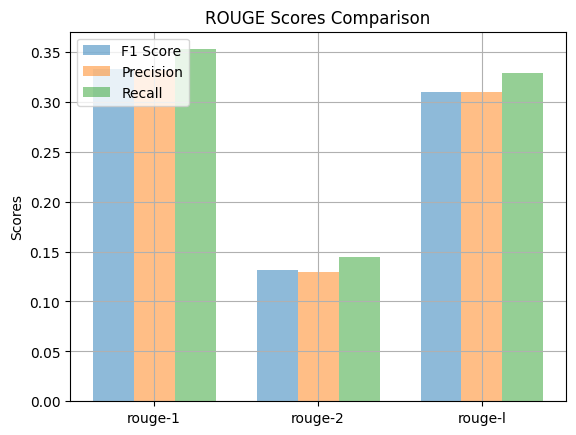

In [ ]:
# Plot the results and create a table

import matplotlib.pyplot as plt

# ROUGE scores data
data = {
'rouge-1': {'f': 0.3326284592708641, 'p': 0.33241629635747677, 'r': 0.35274907245213505},
'rouge-2': {'f': 0.1319279738713805, 'p': 0.12976626620906495, 'r': 0.1448575007278869},
'rouge-l': {'f': 0.3099608304304556, 'p': 0.30973077366146495, 'r': 0.3287271033394071}
}

# Extracting the F1, Precision, and Recall for each ROUGE type
f1_scores = [data[rouge]['f'] for rouge in data]
precision_scores = [data[rouge]['p'] for rouge in data]
recall_scores = [data[rouge]['r'] for rouge in data]
rouge_types = list(data.keys())

# Plotting
fig, ax = plt.subplots()

# Setting the positions and width for the bars
pos = list(range(len(data)))
width = 0.25

# Plotting each metric
plt.bar([p - width for p in pos], f1_scores, width, alpha=0.5, label='F1 Score')
plt.bar(pos, precision_scores, width, alpha=0.5, label='Precision')
plt.bar([p + width for p in pos], recall_scores, width, alpha=0.5, label='Recall')

# Setting the y axis label
ax.set_ylabel('Scores')

# Setting the chart's title
ax.set_title('ROUGE Scores Comparison')

# Setting the position of the x ticks
ax.set_xticks([p for p in pos])

# Setting the labels for the x ticks
ax.set_xticklabels(rouge_types)

# Adding the legend and showing the plot
plt.legend(['F1 Score', 'Precision', 'Recall'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
print(scores)